# Homework 1: Linear Regression & Gradient Descent

## 1. Polynomial regression as linear least squares

1. Show that $\hat{b} = \mathop{\arg\min}\limits_{b} \lVert Xb - \boldsymbol{y} \rVert^2_2 $

    Based on defination, function $\hat{f_b}$ is an empirical risk minimizer if:
    $$\hat{f_b} = \mathop{\arg\min}\limits_{f_b} \hat{R}_n(f_b)$$
    And
    $$\hat{R}_n(f_b) = \frac{1}{n} \sum_{i = 1}^n l(f_b(x_i), y_i)$$
    Based on matrix multiplication,
    $$f_b(x_i) = X_ib$$
    in which $X_i$ denotes the ith line of matrix $X$,
    
    Given loss function $l(f(x), y) = (f(x) - y)^2$ then
    $$
    \begin{aligned}
    \hat{R}_n(f_b) &= \frac{1}{n} \sum_{i = 1}^n l(f_b(x_i), y_i) \\
    &= \frac{1}{n} \sum_{i = 1}^n l(X_ib, y_i) \\
    &= \frac{1}{n} \sum_{i = 1}^n (X_ib - y_i)^2\\
    &= \frac{1}{n} \lVert Xb - \boldsymbol{y} \rVert^2_2
    \end{aligned}
    $$
    Thus,
    $$\hat{f_b} = \frac{1}{n} \mathop{\arg\min}\limits_{f_b} \lVert Xb - \boldsymbol{y} \rVert^2_2$$
    Since $n$ is a definate value and $b$ is the parameters of $f_b$,
    $$\hat{b} = \mathop{\arg\min}\limits_{b} \lVert Xb - \boldsymbol{y} \rVert^2_2$$

2. If $N > d$ and $X$ is full rank, show that $\hat{b} = (X^TX)^{-1}X^T \boldsymbol{y}$.
    
    To solve $\mathop{\arg\min}\limits_{b} \lVert Xb - \boldsymbol{y} \rVert^2_2$, since $min(\lVert Xb - \boldsymbol{y} \rVert^2_2) = 0$, we need to find $b$ to make it = 0.

    $$
    \begin{aligned}
    \lVert Xb - \boldsymbol{y} \rVert^2_2 &= 0 \\
    \Leftrightarrow Xb &= \boldsymbol{y} \\
    \Leftrightarrow X^TXb &= X^T \boldsymbol{y} \\
    \Leftrightarrow (X^TX)^{-1}(X^TX)b &= (X^TX)^{-1}X^T \boldsymbol{y} \\
    \end{aligned}
    $$

    During which process, $(X^TX)$ needs to be invertable. 

    If $rank(X) < N$, there exists $\nu \in \mathbb{R}^N$ with $X \nu = 0$. Then $X^TX\nu = 0$ and $X^TX$ cannot be invertible.

    So $rank(X) >= N$, considering $size(X) = N \times (d + 1)$, then d + 1 >= N, d > N. 

    We need conditions $N > d$ and $X$ full rank to ensure that $(X^TX)^{-1}$ exists.
    

## 2. Gradient descent for ridge/linear regression

### Dataset

1. Modify function `feature_normalization` to normalize all the features to [0, 1].

In [1]:
# import cell
from skeleton_code import load_data
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
### Feature normalization
def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size(num_instances, num_features)
        test - test set, a 2D numpy array of size(num_instances, num_features)

    Returns:
        train_normalized - training set after normalization
        test_normalized - test set after normalization
    """
    l_value = np.min(train, 0)
    r_value = np.max(train, 0)
    is_constant = l_value == r_value

    np.delete(train, is_constant, 1)
    np.delete(test, is_constant, 1)
    np.delete(l_value, is_constant)
    np.delete(r_value, is_constant)
    r_value = r_value - l_value
    
    train_normalized = (train - l_value) / r_value
    test_normalized = (test - l_value) / r_value
    return train_normalized, test_normalized

def load_data():
    #Loading the dataset
    print('loading the dataset')

    df = pd.read_csv('ridge_regression_dataset.csv', delimiter=',')
    X = df.values[:,:-1]
    y = df.values[:,-1]

    print('Split into Train and Test')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=10)

    print("Scaling all to [0, 1]")
    X_train, X_test = feature_normalization(X_train, X_test)
    X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
    X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data()


loading the dataset
Split into Train and Test
Scaling all to [0, 1]


### Linear regression

2. Write the objective function $J(\theta)$ as a matrix/vector expression, without using an explicit summation sign.

    $$J(\theta) = \frac{1}{m} \lVert X\theta - y \rVert^2_2$$

3. Write down an expression for the gradient of $J$ without using an explicit summation sign.

    $$\nabla_\theta J(\theta) = \frac{2}{m} X^T (X\theta - y)$$

4. Write down the expression for updating $\theta$ in the gradient descent algorithm for a step size $\eta$.

    $$\theta \leftarrow \theta - \eta(\frac{2}{m} X^T (X\theta - y))$$

5. Modify the function compute square loss, to compute $J(\theta)$ for a given $\theta$. You might want to create a small dataset for which you can compute $J(\theta)$ by hand, and verify that your compute square loss function returns the correct value.

In [3]:
### The square loss function
def compute_square_loss(X, y, theta):
    """
    Given a set of X, y, theta, compute the average square loss for predicting y with X*theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D array of size(num_features)

    Returns:
        loss - the average square loss, scalar
    """
    num_instances = X.shape[0]
    # print(X.shape, theta.shape, X, np.dot(X, theta), y)
    loss = np.sum(np.power((np.dot(X, theta) - y), 2)) / num_instances
    return loss
    

# X = np.array(range(0, 12)).reshape(4, 3).transpose()
# y = np.array([21, 28, 35])
# theta = np.array([1, 1, 1, 1], dtype=float)
# compute_square_loss(X, y, theta)
theta = np.zeros(X_train.shape[1])
compute_square_loss(X_train,y_train,theta)

7.961518343622414

6. Modify the function compute square loss gradient, to compute $\nabla_\theta J(\theta)$. You may again want to use a small dataset to verify that your compute square loss gradient function returns the correct value.

    $$\nabla_\theta J(\theta) = \frac{2}{m} X^T (X\theta - y)$$

In [4]:
### The gradient of the square loss function
def compute_square_loss_gradient(X, y, theta):
    """
    Compute the gradient of the average square loss(as defined in compute_square_loss), at the point theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    num_instances = X.shape[0]
    # print(np.dot(X, theta))
    loss_gradient = np.dot(X.T, (np.dot(X, theta) - y)) * 2 / num_instances
    
    return loss_gradient

print(compute_square_loss_gradient(X_train, y_train, theta))

[ 0.25182065 -0.15015092 -0.40509526 -0.48635482 -0.09047498 -0.14102752
 -0.19706508 -0.19706508 -0.43171119 -0.64257159 -0.69600073 -0.37699938
 -0.00881756  0.1961221  -0.61472345 -0.71499271 -0.57656883 -0.11765843
 -0.16572975 -0.16572975 -0.16572975 -0.2405182  -0.2405182  -0.2405182
 -0.25532376 -0.25532376 -0.25532376 -0.26195435 -0.26195435 -0.26195435
 -0.2655612  -0.2655612  -0.2655612  -0.29115783 -0.29115783 -0.29115783
 -0.32684613 -0.32684613 -0.32684613 -0.30492033 -0.30492033 -0.30492033
 -0.29459583 -0.29459583 -0.29459583 -0.28881282 -0.28881282 -0.28881282
  0.36972349]


### Gradient Checker

7. Complete the function `grad_checker`.

In [5]:
### Gradient checker
#Getting the gradient calculation correct is often the trickiest part
#of any gradient-based optimization algorithm. Fortunately, it's very
#easy to check that the gradient calculation is correct using the
#definition of gradient.
#See http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4):
    
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions:
(e_1 =(1,0,0,...,0), e_2 =(0,1,0,...,0), ..., e_d =(0,...,0,1))

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by:
(J(theta + epsilon * e_i) - J(theta - epsilon * e_i)) / (2 * epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error

    Return:
        A boolean value indicating whether the gradient is correct or not
    """
    true_gradient = compute_square_loss_gradient(X, y, theta) #The true gradient

    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    
    for i in range(num_features):
        theta_l = np.copy(theta)
        theta_l[i] = theta_l[i] - epsilon
        theta_r = np.copy(theta)
        theta_r[i] = theta_r[i] + epsilon
        approx_grad[i] = (compute_square_loss(X, y, theta_r) - compute_square_loss(X, y, theta_l)) / (2 * epsilon)
    
    return np.linalg.norm(approx_grad - true_gradient) < tolerance

grad_checker(X_train, y_train, theta, epsilon=0.01)

True

### Batch gradient descent

8. Complete `batch_gradient_descent`. Note the phrase $batch$ gradient descent distinguishes between $stochastic$ gradient descent or more generally $minibatch$ gradient descent.

In [6]:
### Batch gradient descent
def batch_grad_descent(X, y, alpha=0.1, num_step=1000, grad_check=False):
    """
    In this question you will implement batch gradient descent to
    minimize the average square loss objective.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        num_step - number of steps to run
        grad_check - a boolean value indicating whether checking the gradient when updating

    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step) is theta_hist[-1]
        loss_hist - the history of average square loss on the data, 1D numpy array,(num_step+1)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_step + 1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_step + 1)  #Initialize loss_hist
    theta = np.zeros(num_features)  #Initialize theta

    loss_hist[0] = compute_square_loss(X, y, theta)
    theta_hist[0] = theta
    for epoch in range(1, num_step + 1):
        if grad_check:
            # Module for gradient diverge debugging
            if grad_checker(X, y, theta) == False:
                print("Alpha = ", alpha)
                print("Gradient failed at epoch: ", epoch)
                break
        gradient = compute_square_loss_gradient(X, y, theta)
        theta = theta - alpha * gradient

        loss_hist[epoch] = compute_square_loss(X, y, theta)
        theta_hist[epoch] = theta
    
    return theta_hist, loss_hist

# theta_hist, loss_hist = batch_grad_descent(X=X_train, y=y_train, alpha=0.01)
# theta = theta_hist[-1]
# compute_square_loss(X_test, y_test, theta)

9. Now let’s experiment with the step size. Note that if the step size is too large, gradient descent may not converge. Starting with a step-size of 0.1, try various diﬀerent ﬁxed step sizes to see which converges most quickly and/or which diverge. As a minimum, try step sizes 0.5, 0.1, .05, and .01. Plot the average square loss on the training set as a function of the number of steps for each step size. Brieﬂy summarize your ﬁndings.

In [7]:
theta_hist_05, loss_hist_05 = batch_grad_descent(X=X_train, y=y_train, alpha=0.5, num_step=1000, grad_check=True)
theta_hist_01, loss_hist_01 = batch_grad_descent(X=X_train, y=y_train, alpha=0.1, num_step=1000, grad_check=True)
theta_hist_005, loss_hist_005 = batch_grad_descent(X=X_train, y=y_train, alpha=0.05, num_step=1000, grad_check=True)
theta_hist_002, loss_hist_002 = batch_grad_descent(X=X_train, y=y_train, alpha=0.02, num_step=1000, grad_check=True)
theta_hist_001, loss_hist_001 = batch_grad_descent(X=X_train, y=y_train, alpha=0.01, num_step=1000, grad_check=True)

Alpha =  0.5
Gradient failed at epoch:  6
Alpha =  0.1
Gradient failed at epoch:  13


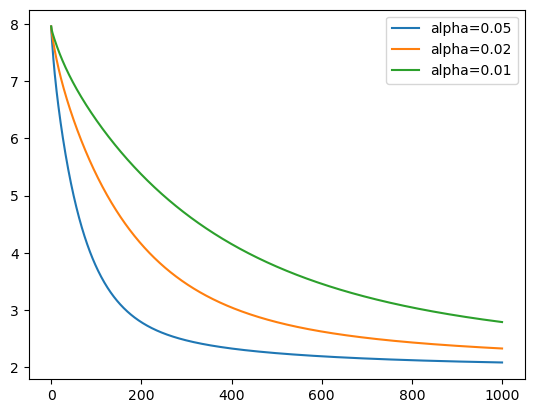

In [8]:
from matplotlib import pyplot as pyplot

plt.plot(loss_hist_005, label="alpha=0.05")
plt.plot(loss_hist_002, label="alpha=0.02")
plt.plot(loss_hist_001, label="alpha=0.01")
plt.legend(loc=1)

As we can see from the curve chart, the larger the alpha is, meaning the larger step size, the faster the value of the objective loss function decreases. The gradient diverge at step 6 when alpha = 0.5 and at step 13 when alpha = 0.1

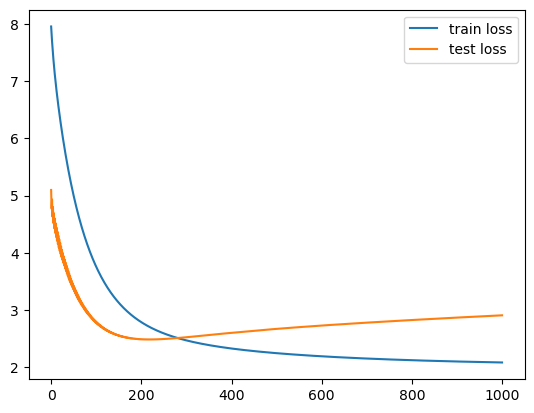

In [9]:
test_loss_hist = np.array([compute_square_loss(X_test, y_test, theta) for theta in theta_hist_005])

plt.plot(loss_hist_005, label="train loss")
plt.plot(test_loss_hist, label="test loss")
plt.legend(loc=1)

### Ridge Regression

11. Compute the gradient of $J_\lambda(\theta)$ and write down the expression for updating $\theta$ in the gradient descent algorithm.

    $$
    \begin{aligned}
    \nabla_\theta(J_\theta)
    &= \frac{2}{m} (X \theta - y)^T \frac{\partial(X \theta - y)}{\partial \theta} + \frac{\partial \lambda \theta^T \theta}{\partial \theta} \\
    &= \frac{2}{m} X^T (X \theta - y) + 2 \lambda \theta^T
    \end{aligned}
    $$


12. Implement compute `regularized_square_loss_gradient`.

In [10]:
### The gradient of regularized batch gradient descent
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized average square loss function given X, y and theta

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        lambda_reg - the regularization coefficient

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    num_instances = X.shape[0]
    gradient = np.dot(X.T, np.dot(X, theta) - y) * 2 / num_instances + 2 * lambda_reg * theta
    return gradient

13. Implement `regularized_grad_descent`.

In [11]:
### Regularized batch gradient descent
def regularized_grad_descent(X, y, alpha=0.05, lambda_reg=10**-2, num_step=1000):
    """
    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        num_step - number of steps to run
    
    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step+1) is theta_hist[-1]
        loss hist - the history of average square loss function without the regularization term, 1D numpy array.
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.zeros(num_features) #Initialize theta
    theta_hist = np.zeros((num_step+1, num_features)) #Initialize theta_hist
    loss_hist = np.zeros(num_step+1) #Initialize loss_hist
    
    loss_hist[0] = compute_square_loss(X, y, theta)
    theta_hist[0] = theta
    for epoch in range(1, num_step + 1):
        gradient = compute_regularized_square_loss_gradient(X, y, theta, lambda_reg=lambda_reg)
        theta = theta - alpha * gradient

        loss_hist[epoch] = compute_square_loss(X, y, theta)
        theta_hist[epoch] = theta
    
    return theta_hist, loss_hist

regularized_grad_descent(X_train, y_train)

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.01259103,  0.00750755,  0.02025476, ...,  0.01444064,
          0.01444064, -0.01848617],
        [-0.05578979, -0.01564905,  0.0099683 , ...,  0.00768725,
          0.00768725, -0.06755668],
        ...,
        [-1.34404296,  0.56947785,  1.39108433, ...,  0.02896084,
          0.02896084, -1.18793078],
        [-1.34409056,  0.56951581,  1.39090374, ...,  0.02892136,
          0.02892136, -1.18783728],
        [-1.34413798,  0.56955381,  1.39072342, ...,  0.02888194,
          0.02888194, -1.18774399]]),
 array([7.96151834, 7.82651953, 7.70402325, ..., 2.28492578, 2.28482008,
        2.28471467]))

14. Choosing a reasonable step-size, plot training average square loss and the test average square loss (just the average square loss part, without the regularization, in each case) as a function of the training iterations for various values of $\lambda$. What do you notice in terms of overﬁtting?

Text(0.5, 1.0, 'lambda = .001')

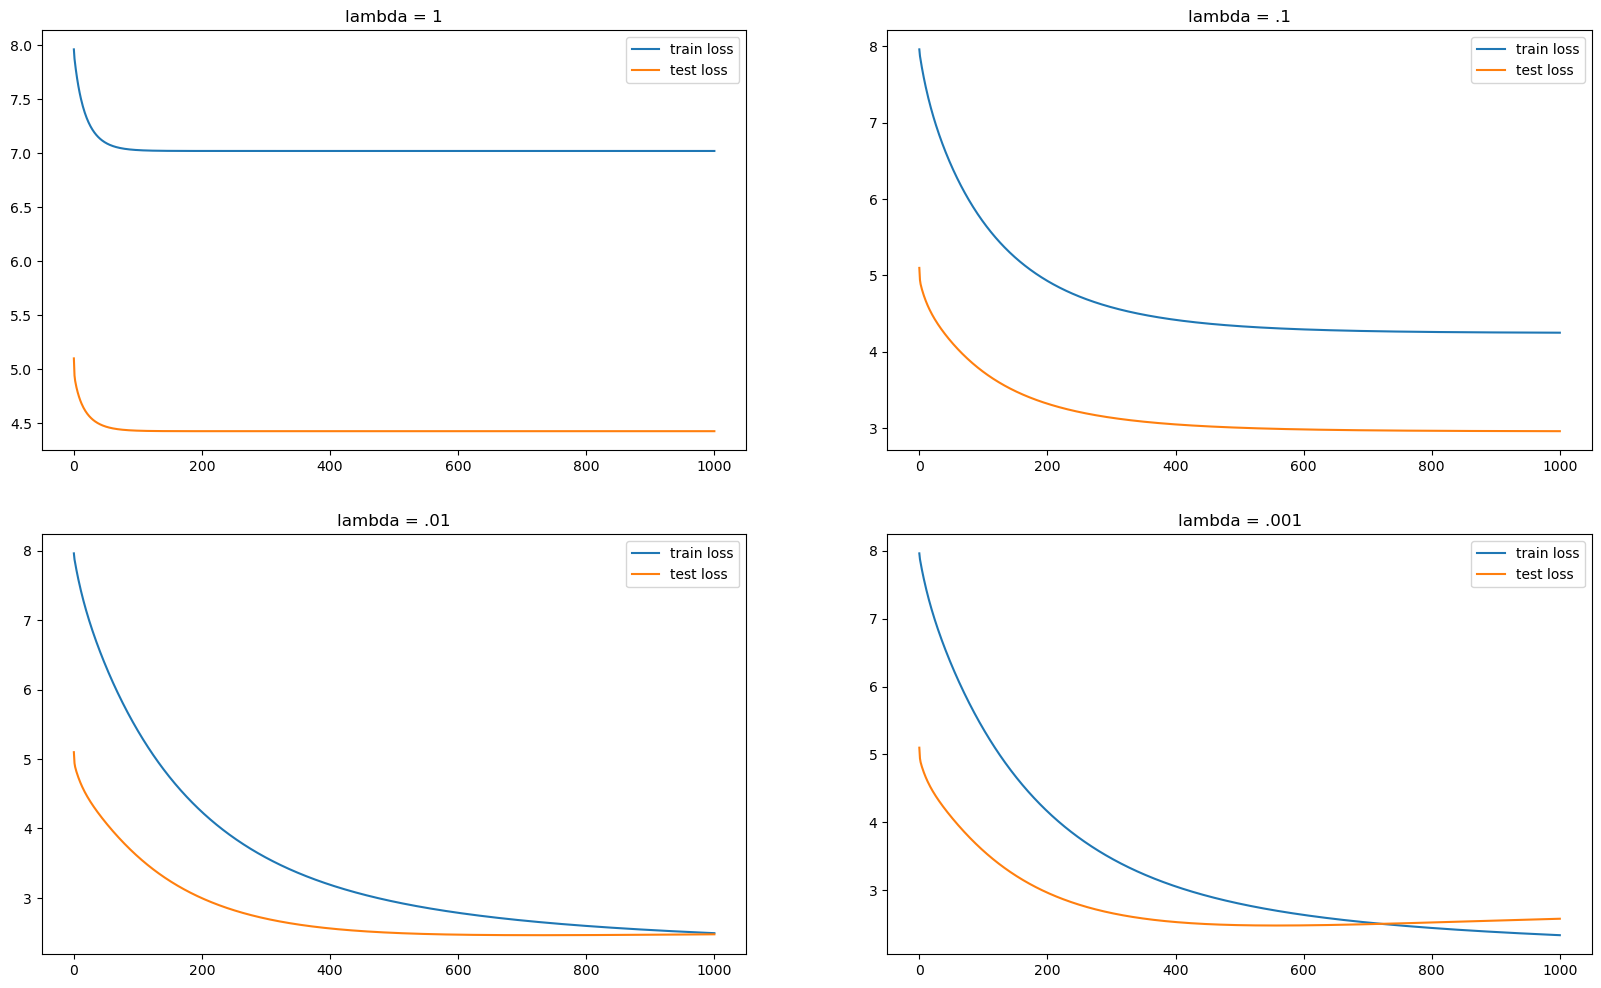

In [12]:
plt.figure(figsize=(20, 12))

alpha = 0.02
theta_hist, loss_hist = regularized_grad_descent(X_train, y_train, lambda_reg=1, alpha=alpha)
test_loss_hist = np.array([compute_square_loss(X_test, y_test, theta) for theta in theta_hist])

plt.subplot(2, 2, 1)
plt.plot(loss_hist, label="train loss")
plt.plot(test_loss_hist, label="test loss")
plt.legend(loc=1)
plt.title("lambda = 1")

theta_hist, loss_hist = regularized_grad_descent(X_train, y_train, lambda_reg=0.1, alpha=alpha)
test_loss_hist = np.array([compute_square_loss(X_test, y_test, theta) for theta in theta_hist])

plt.subplot(2, 2, 2)
plt.plot(loss_hist, label="train loss")
plt.plot(test_loss_hist, label="test loss")
plt.legend(loc=1)
plt.title("lambda = .1")

theta_hist, loss_hist = regularized_grad_descent(X_train, y_train, lambda_reg=0.01, alpha=alpha)
test_loss_hist = np.array([compute_square_loss(X_test, y_test, theta) for theta in theta_hist])

plt.subplot(2, 2, 3)
plt.plot(loss_hist, label="train loss")
plt.plot(test_loss_hist, label="test loss")
plt.legend(loc=1)
plt.title("lambda = .01")

theta_hist, loss_hist = regularized_grad_descent(X_train, y_train, lambda_reg=0.001, alpha=alpha)
test_loss_hist = np.array([compute_square_loss(X_test, y_test, theta) for theta in theta_hist])

plt.subplot(2, 2, 4)
plt.plot(loss_hist, label="train loss")
plt.plot(test_loss_hist, label="test loss")
plt.legend(loc=1)
plt.title("lambda = .001")

As we can see from the figure above ($\alpha = 0.02$), the larger the value of lambda, meaning considering more weight of absolute value of the coefficient, the less overfitting the training result will be. But too large lambda might cause underfitting, as shown in figure 1.

15. Plot the training average square loss and the test average square loss at the end of training as a function of $\lambda$. You may want to have $log(\lambda)$ on the x-axis rather than $\lambda$. Which value of $\lambda$ would you choose ?

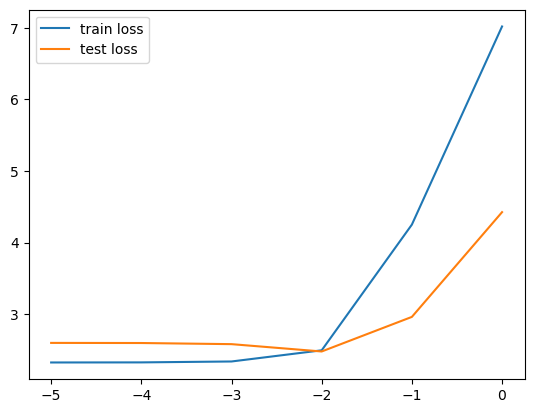

In [13]:
train_loss = []
test_loss = []
lambda_list = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0.00001])
for lambda_reg in lambda_list:
    theta_hist, loss_hist = regularized_grad_descent(X_train, y_train, lambda_reg=lambda_reg, alpha=alpha)
    train_loss.append(loss_hist[-1])
    theta = theta_hist[-1]
    test_loss.append(compute_square_loss(X_test, y_test, theta))

plt.plot(np.log10(lambda_list), train_loss, label="train loss")
plt.plot(np.log10(lambda_list), test_loss, label="test loss")
plt.legend(loc=0)

As the figure shows, the best lambda = 0.01

### Stochastic Gradient Descent (SGD) (optional)

16. Show that the objective function
    $$J_\lambda(\theta) = \frac{1}{m} \sum_{i = 1}^{m} (h_\theta(x_i) - y_i)^2 + \lambda\theta^T\theta$$
    can be written into form $J_\lambda(\theta) = \frac{1}{m} \sum_{i = 1}{m} f_i(\theta)$ by giving an $f_i(\theta)$.

    $$J_\lambda(\theta) = \frac{1}{m} \sum_{i = 1}^{m} ((h_\theta(x_i) - y_i)^2 + \lambda\theta^T\theta)$$
    so let $f_i(\theta) = (h_\theta(x_i) - y_i)^2 + \lambda\theta^T\theta$ make two expressions equivalent.

17. Show that the stochastic gradient $\nabla_\theta f_i(\theta)$, for $i$ chosen uniformly at random from {1, . . . , m} , is an unbiased estimator of $\nabla_\theta J_\lambda(\theta)$.

    $$ \mathbb{E}[\nabla f_i(\theta)] = \sum_{j = 1}^{m} P(j = i) \times \nabla f_j(\theta) $$

    Since the examples are chosen uniformly at random, all their probabilities $(P(j = i))$ are equal to $\frac{1}{n}$, so it's just the average value of the gradient over all examples, so

    $$
    \begin{aligned}
    \sum_{j = 1}^{m} P(j = i) \times \nabla f_j(\theta) &= \frac{1}{m} \sum_{j = 1}{m} \nabla f_j(\theta) \\
    &= \nabla_\theta J_\lambda(\theta) \\
    \therefore \mathbb{E}[\nabla f_i(\theta)] &= \nabla_\theta J_\lambda(\theta)
    \end{aligned}
    $$

18. Write down the update rule for $\theta$ in SGD for the ridge regression objective function.

    $$\theta \leftarrow \theta - \eta (2 x_i^T (x_i \theta - y_i) + 2 \lambda \theta^T)$$

19. Implement `stochastic_grad_descent`.

In [14]:
### Stochastic gradient descent
def stochastic_grad_descent(X, y, alpha=0.01, lambda_reg=10**-2, num_epoch=1000, eta0=False):
    """
    In this question you will implement stochastic gradient descent with regularization term

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - string or float, step size in gradient descent
                NOTE: In SGD, it's not a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every step is the float.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t).
                if alpha == "1/t", alpha = 1/t.
        lambda_reg - the regularization coefficient
        num_epoch - number of epochs to go through the whole training set

    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size(num_epoch, num_instances, num_features)
                     for instance, theta in epoch 0 should be theta_hist[0], theta in epoch(num_epoch) is theta_hist[-1]
        loss hist - the history of loss function vector, 2D numpy array of size(num_epoch, num_instances)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta

    theta_hist = np.zeros((num_epoch + 1, num_instances, num_features)) #Initialize theta_hist
    loss_hist = np.zeros((num_epoch + 1, num_instances)) #Initialize loss_hist

    p = np.random.permutation(len(X))
    X_shuffled = X[p]
    y_shuffled = y[p]

    loss_hist[0] = compute_square_loss(X, y, theta)
    theta_hist[0] = theta
    for epoch in range(1, num_epoch + 1):
        for i in range(X_shuffled.shape[0]):
            xi = X_shuffled[i]
            yi = y_shuffled[i]
            if alpha=='1/sqrt(t)':
                step_size = 1.0 / np.sqrt((i + 1.0))
            elif alpha=='1/t':
                step_size = 1.0 / (i + 1.0)
            else:
                step_size = alpha
            gradient = compute_regularized_square_loss_gradient(xi, yi, theta, lambda_reg=lambda_reg)
            theta = theta - step_size * gradient

            loss_hist[epoch][i] = compute_square_loss(X, y, theta)
            theta_hist[epoch][i] = theta

    return theta_hist, loss_hist

20. For each step size rule, plot the value of the objective function (or the log of the objective function if that is more clear) as a function of epoch (or step number, if you prefer). How do the results compare?

In [15]:
theta_hist_05, loss_hist_05 = stochastic_grad_descent(X=X_train, y=y_train, alpha=0.05)
theta_hist_01, loss_hist_01 = stochastic_grad_descent(X=X_train, y=y_train, alpha=0.01)
theta_hist_005, loss_hist_005 = stochastic_grad_descent(X=X_train, y=y_train, alpha=0.005)
theta_hist_t, loss_hist_t = stochastic_grad_descent(X=X_train, y=y_train, alpha='1/t')
theta_hist_sqrt, loss_hist_sqrt = stochastic_grad_descent(X=X_train, y=y_train, alpha='1/sqrt(t)')

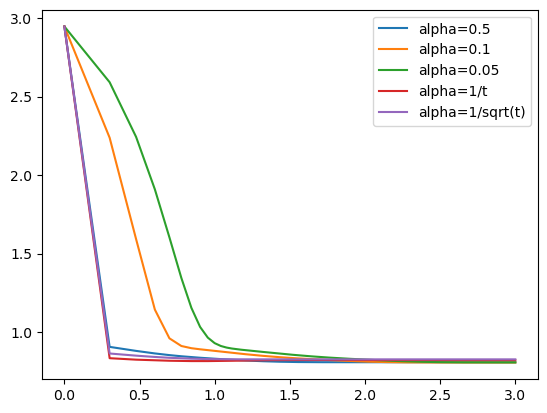

In [16]:
plt.plot(np.log10(range(1, 1002)), np.log10(loss_hist_05[:, -1]), label="alpha=0.5")
plt.plot(np.log10(range(1, 1002)), np.log10(loss_hist_01[:, -1]), label="alpha=0.1")
plt.plot(np.log10(range(1, 1002)), np.log10(loss_hist_005[:, -1]), label="alpha=0.05")
plt.plot(np.log10(range(1, 1002)), np.log10(loss_hist_t[:, -1]), label="alpha=1/t")
plt.plot(np.log10(range(1, 1002)), np.log10(loss_hist_sqrt[:, -1]), label="alpha=1/sqrt(t)")
plt.legend(loc=1)

From the figure we can see that compared to a constant step size, the step size decrease with step number decreases the loss faster at the beginning and can reduce the loss to a lower value at the end. Using the square root of step size can reduce the loss to a lower value.

## 3. Image classiﬁcation with regularized logistic regression

### Dataset

In [17]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1')
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test

### Logistic regression

21. Show that given that we chose the convention $y_i \in \{-1, 1\}$, our objective function over the training data $\{x_i, y_i\}_{i = 1}^m$ can be re-written as $$L(\theta) = \frac{1}{2m} \sum_{i = 1}^m(1 + y_i)log(1 + e^{-h_{\theta, b}(x_i)}) + (1 - y_i)log(1 + e^{h_{\theta, b}(x_i)})$$

    introduce sigmoid function: $\sigma(z) = \frac{1}{1 + e^{-z}}$
    $L(\theta)$ is the mean value of loss of every instance $l_{Logistic}$.
    $$
    \begin{aligned}
    l_{Logistic} &= \frac{1}{2} ((1 + y_i)log(1 + e^{-h_{\theta, b}(x_i)}) + (1 - y_i)log(1 + e^{h_{\theta, b}(x_i)})) \\
    &= \left\{
        \begin{aligned}
            log(1 + e^{h_{\theta, b}(x_i)}), y &= -1 \\
            log(1 + e^{-h_{\theta, b}(x_i)}), y &= 1
        \end{aligned}
    \right. \\
    &= \left\{
        \begin{aligned}
            -log(\sigma(-h_{\theta, b}(x_i))), y &= -1 \\
            -log(\sigma(h_{\theta, b}(x_i))), y &= 1
        \end{aligned}
    \right. \\
    &= -log(\sigma(y \cdot h_{\theta, b}(x_i))) \\
    &= log(1 + e^{-y \cdot h_{\theta, b}(x_i)}) \\
    &= log(1 + e^{-m_i})
    \end{aligned}
    $$
    so, the defination of loss can be reprecented as a function of the margin $m_i$
    $$loss = \frac{1}{n} \sum_{i = 1}^n log(1 + e^{-m_i})$$
    and it can be re-written as $L(\theta)$ mentioned above.

22. What will become the loss function if we regularize the coeﬃcients of $\theta$ with an $l_1$ penalty using a regularization parameter $\alpha$?

    $$L(\theta) = \frac{1}{2m} \sum_{i = 1}^m(1 + y_i)log(1 + e^{-h_{\theta, b}(x_i)}) + (1 - y_i)log(1 + e^{h_{\theta, b}(x_i)}) + \alpha \sum_{i = 1}^N \lvert \theta_i \rvert$$

23. Using the method `clf.predict()` from the classiﬁer write a function that takes as input an `SGDClassifier` which we will call `clf`, a design matrix $X$ and a target vector $y$ and returns the classiﬁcation error.

In [18]:
X_train, X_test, y_train, y_test = pre_process_mnist_01()

clf = SGDClassifier(loss='log_loss', max_iter=1000,
                    tol=1e-3,
                    penalty='l1', alpha=0.01,
                    learning_rate='invscaling',
                    power_t=0.5, 
                    eta0=0.01,
                    verbose=0)
clf.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


SGDClassifier(alpha=0.01, eta0=0.01, learning_rate='invscaling',
              loss='log_loss', penalty='l1')

In [19]:
def classification_error(clf, X, y):
    y_hat = clf.predict(X)
    return np.sum(y_hat != y) / y.shape[0]

classification_error(clf, X_train, y_train)

0.0021207836800646333

24. 

In [20]:
def sub_sample(N_train, X_train, y_train):
    """
    Subsample the training data to keep only N first elements
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    assert N_train <= X_train.shape[0]
    return X_train[:N_train, :], y_train[:N_train]



In [21]:
alpha_list = np.arange(-4, -0.99, (-1 - (-4)) / 10)
alpha_list = 10 ** alpha_list
err_list = np.zeros((11, 10))

for i in range(11):
    for j in range(10):
        X_train_sub, y_train_sub = sub_sample(100, X_train, y_train)
        clf = SGDClassifier(loss='log_loss', max_iter=1000,
                            tol=1e-3,
                            penalty='l1', alpha=alpha_list[i],
                            learning_rate='invscaling',
                            power_t=0.5, 
                            eta0=0.01,
                            verbose=0)
        clf.fit(X_train_sub, y_train_sub)
        err_list[i][j] = classification_error(clf, X_train, y_train)

<ErrorbarContainer object of 3 artists>

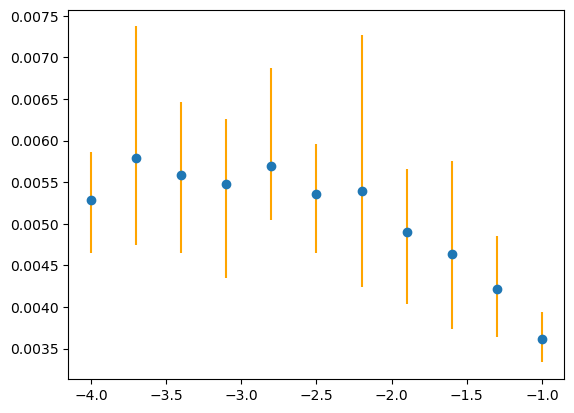

In [22]:
mean_err = np.mean(err_list, axis=1)
y_err_min = mean_err - np.min(err_list, axis=1)
y_err_max = np.max(err_list, axis=1) - mean_err
plt.errorbar(np.log10(alpha_list), mean_err, yerr=[y_err_min, y_err_max], fmt ='o', ecolor='orange')

25. Which source(s) of randomness are we averaging over by repeating the experiment?

    - The 100 data points are randomly chosen from the whole set.
    - Stochastic regrassion process updates theta with randomly chosen data points.

26. What is the optimal value of the parameter α among the values you tested?

    $\alpha = 0.1$

27. Finally, for one run of the ﬁt for each value of $\alpha$ plot the value of the fitted $theta$. You can access it via `clf.coef` , and should reshape the 764 dimensional vector to a 28×28 arrray to visualize it with plt.imshow.

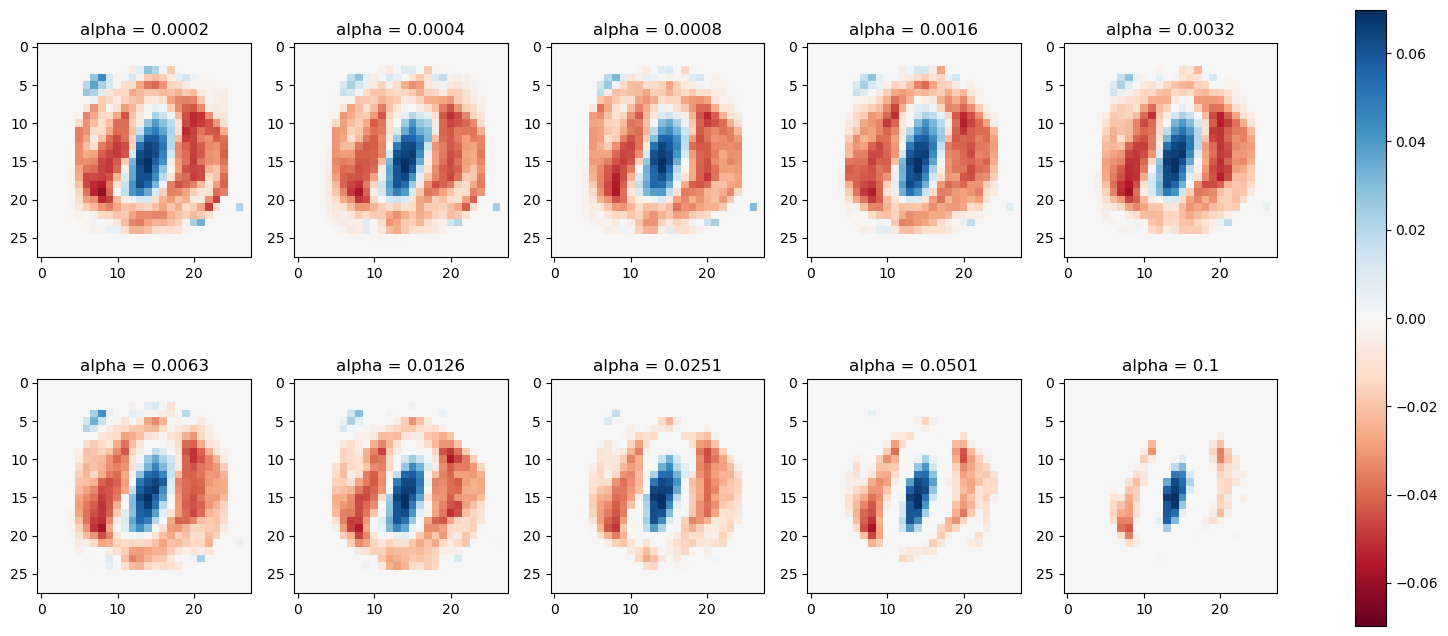

In [23]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

i = 1
for ax in axes.flat:
    X_train_sub, y_train_sub = sub_sample(100, X_train, y_train)
    clf = SGDClassifier(loss='log_loss', max_iter=1000,
                            tol=1e-3,
                            penalty='l1', alpha=alpha_list[i],
                            learning_rate='invscaling',
                            power_t=0.5, 
                            eta0=0.01,
                            verbose=0)
    clf.fit(X_train_sub, y_train_sub)

    scale = np.abs(clf.coef_).max()
    im = ax.imshow(clf.coef_.reshape(28, 28), cmap=plt.cm.RdBu, vmax=scale, vmin=-scale)
    ax.title.set_text("alpha = " + str(np.round(alpha_list[i], 4)))
    i = i + 1
fig.colorbar(im, ax=axes)

28. What can you note about the pattern in $\theta$? What can you note about the effect of the regularization?

    After regularization, the theta will be more simple. In case the model to be overfitting or too complex, we can use regularization. As shown in the figure above, a larger alpha means a more simple output of theta, making the model more robust and contributing to higher accuracy.